In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
# Cell 1: imports & basic config
from lib.graphlib import GraphLib
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time
import seaborn as sns
from qiskit_aer import AerSimulator
from pathlib import Path

# add repo root (parent of notebooks/) to sys.path
sys.path.append(str(Path.cwd().parent))

# Notebook defaults
AER_BACKEND = AerSimulator()
QAOA_SHOTS = 1024  # simulator shots for validating angles
EDGE_PROB = 0.2
WEIGHT_RANGE = (1, 5)

# Sweep sizes (you can change / expand)
NS_SMALL = list(range(6, 12, 2))
NS_LARGE = list(range(22, 24, 2))
NS_ALL = NS_SMALL + NS_LARGE

# Repeats per size
REPEATS_SMALL = 5
REPEATS_LARGE = 3

# For plotting aesthetics
sns.set_theme(context="talk", style="whitegrid")  # same as seaborn-talk

In [68]:
# Cell 2: helper to run one graph instance and return results as dict
def run_single_instance(n, edge_prob=EDGE_PROB, weight_range=WEIGHT_RANGE, shots=QAOA_SHOTS, compute_optimal=True):
    """
    Generate a random graph with n nodes and run:
      - classical approximations (random, local search)
      - qaoa p=1 analytic optimize + simulated validation (shots)
      - optional brute-force exact optimum if compute_optimal True
    Returns a dict with values and timings.
    """
    g = GraphLib()
    g.generate_random_graph(
        num_vertices=n, edge_prob=edge_prob, weight_range=weight_range, seed=None)

    out = {'n': n}
    # Classical random approx
    t0 = time.time()
    _, w_rand = g.max_cut_random(trials=2000)
    t_rand = time.time() - t0
    out.update({'rand_cut': w_rand, 'rand_time': t_rand})

    # Classical local search approx
    t0 = time.time()
    _, w_local = g.max_cut_local_search(iterations=200)
    t_local = time.time() - t0
    out.update({'local_cut': w_local, 'local_time': t_local})

    # Brute force optimal if allowed for small n
    if compute_optimal:
        t0 = time.time()
        _, w_opt = g.max_cut_bruteforce()
        t_opt = time.time() - t0
        out.update({'opt_cut': w_opt, 'opt_time': t_opt})
    else:
        out.update({'opt_cut': None, 'opt_time': None})

    # QAOA p=1: analytic optimization (fast)
    t0 = time.time()
    gamma_star, beta_star, val_star, _ = g.optimize_qaoa1_classical(
        grid_res=41, refine=True)
    t_qaoa_opt = time.time() - t0
    out.update({'qaoa_gamma': gamma_star, 'qaoa_beta': beta_star,
               'qaoa_analytic_val': val_star, 'qaoa_opt_time': t_qaoa_opt})

    # Validate via simulator (shots)
    t0 = time.time()
    res = g.qaoa1_expectation_simulated(
        gamma_star, beta_star, shots=shots, backend=AER_BACKEND)
    t_qaoa_sim = time.time() - t0
    # res includes 'expectation' (sampled average), 'best_cut' (best sample)
    out.update({
        'qaoa_sampled_expectation': res['expectation'],
        'qaoa_best_cut': res['best_cut'],
        'qaoa_counts': res['counts'],
        'qaoa_sim_time': t_qaoa_sim,
        'qaoa_shots': shots
    })
    return out

In [69]:
# Cell 3: sweep driver that runs multiple repeats per n and collects results
def sweep_ns(ns_list, repeats_small=REPEATS_SMALL, repeats_large=REPEATS_LARGE):
    rows = []
    for n in ns_list:
        repeats = repeats_small if n <= 20 else repeats_large
        print(f"Running n={n} with {repeats} repeats ...")
        for r in range(repeats):
            row = run_single_instance(n, edge_prob=EDGE_PROB, weight_range=WEIGHT_RANGE,
                                      shots=QAOA_SHOTS, compute_optimal=(n <= 20))
            row['repeat'] = r
            rows.append(row)
    df = pd.DataFrame(rows)
    return df


# Run the sweep (this will take time depending on NS_ALL and repeats)
df = sweep_ns(NS_ALL, repeats_small=REPEATS_SMALL, repeats_large=REPEATS_LARGE)

Running n=6 with 5 repeats ...
Running n=8 with 5 repeats ...
Running n=10 with 5 repeats ...
Running n=22 with 3 repeats ...


In [70]:
# Cell 4: quick peek at collected data (optional)
df.head()

,n,rand_cut,rand_time,local_cut,local_time,opt_cut,opt_time,qaoa_gamma,qaoa_beta,qaoa_analytic_val,qaoa_opt_time,qaoa_sampled_expectation,qaoa_best_cut,qaoa_counts,qaoa_sim_time,qaoa_shots,repeat
0,6,6,0.082948,5,0.000101,6.0,0.001511,1.570796,0.392699,6.000000,0.106182,3.025391,6,"{'000100': 11, '110011': 15, '101101': 20, '11...",0.258953,1024,0
1,6,6,0.099083,2,0.000068,6.0,0.000896,1.570796,0.392699,6.000000,0.081158,2.994141,6,"{'000011': 13, '110100': 16, '101100': 27, '01...",0.260851,1024,1
2,6,9,0.109066,8,0.000111,9.0,0.001611,0.620501,0.318210,7.345198,0.134953,5.270508,9,"{'001110': 1, '111011': 33, '100101': 36, '001...",0.378838,1024,2
3,6,3,0.111527,3,0.000074,3.0,0.000959,1.570796,0.392699,3.000000,0.077143,1.587891,3,"{'010100': 22, '011110': 16, '111100': 17, '10...",0.245240,1024,3
4,6,2,0.107921,0,0.000095,2.0,0.001427,1.570796,0.392699,2.000000,0.098938,1.039062,2,"{'100101': 15, '001110': 18, '111011': 20, '01...",0.315038,1024,4


In [71]:
# Cell 5: compute aggregated metrics per n and algorithm; compute approximation ratios
def compute_aggregates(df):
    # Compute group stats
    agg = df.groupby('n').agg({
        'opt_cut': ['mean', 'std', 'count'],
        'rand_cut': ['mean', 'std'],
        'local_cut': ['mean', 'std'],
        'qaoa_best_cut': ['mean', 'std'],
        'rand_time': ['mean', 'std'],
        'local_time': ['mean', 'std'],
        'qaoa_sim_time': ['mean', 'std'],
        'opt_time': ['mean', 'std']
    })
    agg.columns = ['_'.join(col).strip() for col in agg.columns.values]
    agg = agg.reset_index()

    # Compute SEM = std / sqrt(n_samples)
    for col in ['opt_cut', 'rand_cut', 'local_cut', 'qaoa_best_cut',
                'rand_time', 'local_time', 'qaoa_sim_time', 'opt_time']:
        if f'{col}_std' in agg.columns and f'{col}_count' in agg.columns:
            agg[f'{col}_sem'] = agg[f'{col}_std'] / \
                np.sqrt(agg[f'{col}_count'])
        elif f'{col}_std' in agg.columns:
            # fallback if count missing (for times, etc.)
            agg[f'{col}_sem'] = agg[f'{col}_std'] / \
                np.sqrt(len(df[df['n'] == agg['n'].iloc[0]]))
    return agg

agg_df = compute_aggregates(df)

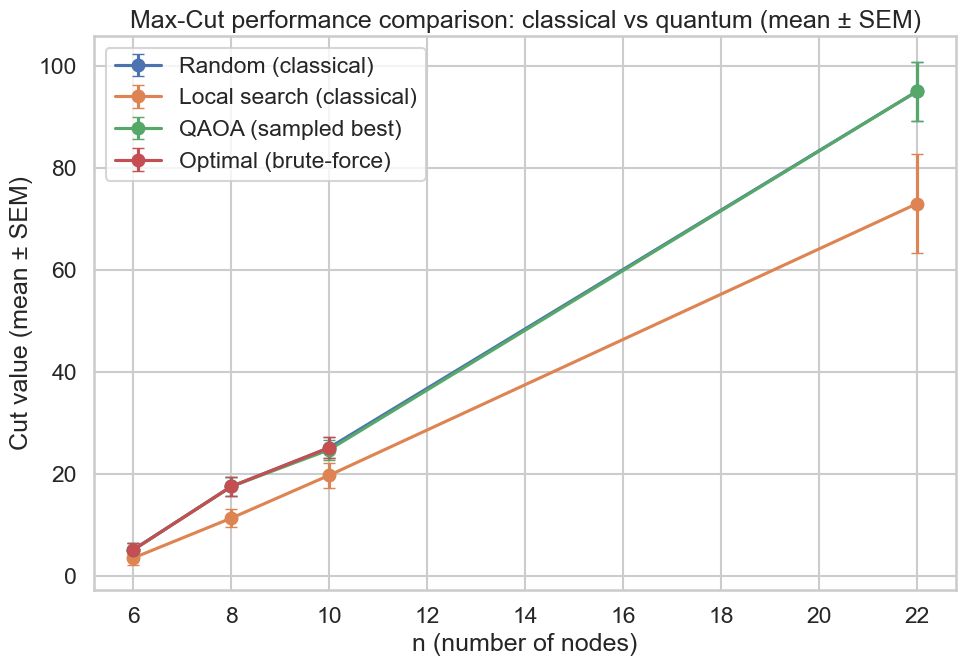

In [72]:
# Cell 6: plots with error bars using precomputed std columns
def plot_cut_values(agg_df):
    plt.figure(figsize=(10, 7))

    def errplot(x, y, yerr, label, **kwargs):
        plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=4, label=label, **kwargs)

    errplot(agg_df['n'], agg_df['rand_cut_mean'], agg_df['rand_cut_sem'], 'Random (classical)')
    errplot(agg_df['n'], agg_df['local_cut_mean'], agg_df['local_cut_sem'], 'Local search (classical)')
    errplot(agg_df['n'], agg_df['qaoa_best_cut_mean'], agg_df['qaoa_best_cut_sem'], 'QAOA (sampled best)')
    if 'opt_cut_mean' in agg_df.columns and agg_df['opt_cut_mean'].notnull().any():
        errplot(agg_df['n'], agg_df['opt_cut_mean'], agg_df['opt_cut_sem'], 'Optimal (brute-force)')

    plt.xlabel('n (number of nodes)')
    plt.ylabel('Cut value (mean ± SEM)')
    plt.title('Max-Cut performance comparison: classical vs quantum (mean ± SEM)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_cut_values(agg_df)

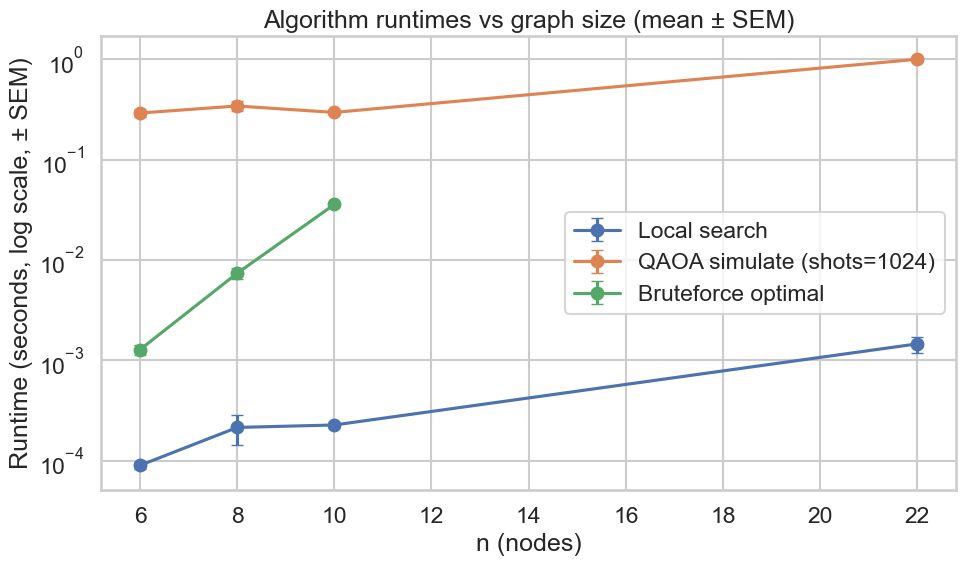

In [73]:
# Cell 7: runtime plots with error bars (log scale)
def plot_runtimes(agg_df):
    plt.figure(figsize=(10, 6))

    def errplot(x, ymean, yerr, label, **kwargs):
        plt.errorbar(x, ymean, yerr=yerr, fmt='-o',
                     capsize=4, label=label, **kwargs)

    errplot(agg_df['n'], agg_df['local_time_mean'],
            agg_df['local_time_sem'], 'Local search')
    errplot(agg_df['n'], agg_df['qaoa_sim_time_mean'],
            agg_df['qaoa_sim_time_sem'], f'QAOA simulate (shots={QAOA_SHOTS})')
    if 'opt_time_mean' in agg_df.columns and agg_df['opt_time_mean'].notnull().any():
        errplot(agg_df['n'], agg_df['opt_time_mean'],
                agg_df['opt_time_sem'], 'Bruteforce optimal')

    plt.yscale('log')
    plt.xlabel('n (nodes)')
    plt.ylabel('Runtime (seconds, log scale, ± SEM)')
    plt.title('Algorithm runtimes vs graph size (mean ± SEM)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_runtimes(agg_df)

In [75]:
# Cell 8: save raw and aggregated results (optional)
df.to_csv('../data/maxcut_simulation_raw_results.csv', index=False)
agg_df.to_csv('../data/maxcut_simulation_aggregates.csv', index=False)
print("Saved CSVs: raw and aggregates.")

Saved CSVs: raw and aggregates.
